In [1]:
import torch

print(torch.cuda.is_available())
print(torch.backends.mps.is_available())

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

False
True


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomAffine
from torch.utils.data import DataLoader
from PIL import Image

transform = Compose([
    RandomRotation(10),
    RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

train_dataset = MNIST('data', train=True, transform=transform, download=True)
test_dataset = MNIST('data', train=False, transform=Compose([ToTensor(), Normalize((0.5,), (0.5,))]), download=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FullyConnectedNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

epochs = 1000
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

model.eval()
predictions = []
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

import pandas as pd
data = {
    "ID": list(range(len(predictions))),
    "target": predictions
}
df = pd.DataFrame(data)
df.to_csv("submission.csv", index=False)


Epoch 1/1000, Loss: 2857.8867, Test Accuracy: 95.64%
Epoch 2/1000, Loss: 1987.5088, Test Accuracy: 96.76%
Epoch 3/1000, Loss: 1771.1120, Test Accuracy: 97.13%
Epoch 4/1000, Loss: 1632.4473, Test Accuracy: 97.35%
Epoch 5/1000, Loss: 1571.4870, Test Accuracy: 97.64%
Epoch 6/1000, Loss: 1483.8421, Test Accuracy: 97.86%
Epoch 7/1000, Loss: 1467.3141, Test Accuracy: 98.10%
Epoch 8/1000, Loss: 1451.6392, Test Accuracy: 97.90%
Epoch 9/1000, Loss: 1437.4361, Test Accuracy: 98.19%
Epoch 10/1000, Loss: 1415.4109, Test Accuracy: 98.21%
Epoch 11/1000, Loss: 1368.1824, Test Accuracy: 98.28%
Epoch 12/1000, Loss: 1353.4811, Test Accuracy: 98.42%
Epoch 13/1000, Loss: 1334.1636, Test Accuracy: 98.09%
Epoch 14/1000, Loss: 1333.2200, Test Accuracy: 98.31%
Epoch 15/1000, Loss: 1360.5233, Test Accuracy: 98.27%
Epoch 16/1000, Loss: 1291.9524, Test Accuracy: 98.39%
Epoch 17/1000, Loss: 1288.0322, Test Accuracy: 98.20%
Epoch 18/1000, Loss: 1274.1553, Test Accuracy: 98.39%
Epoch 19/1000, Loss: 1286.7859, Test 

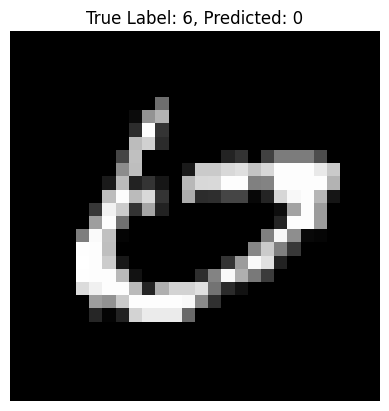

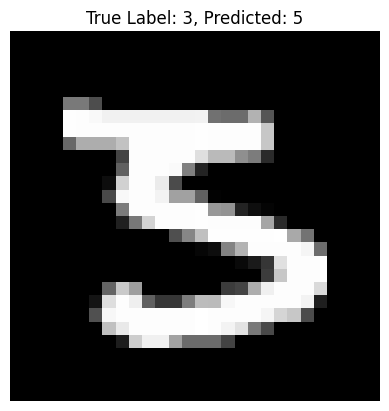

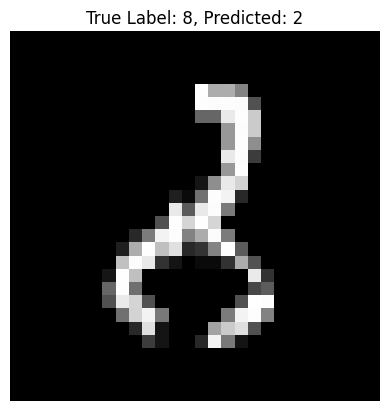

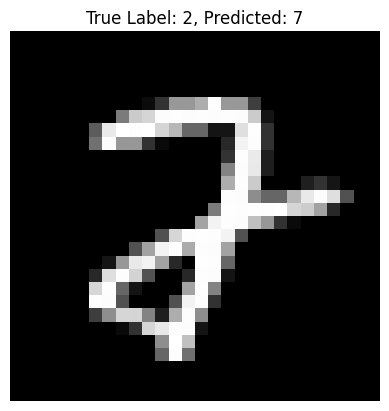

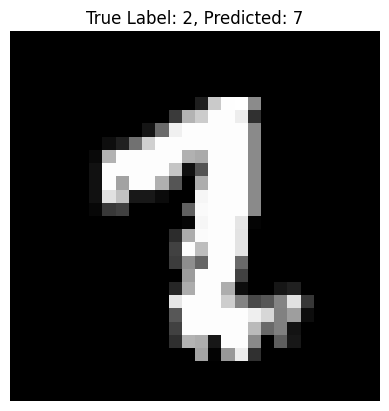

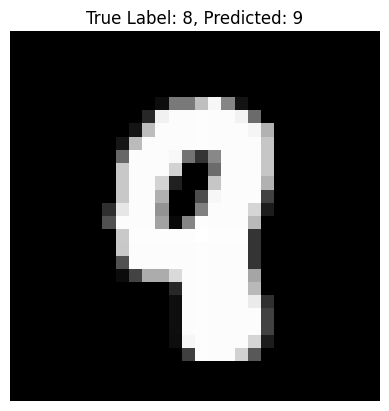

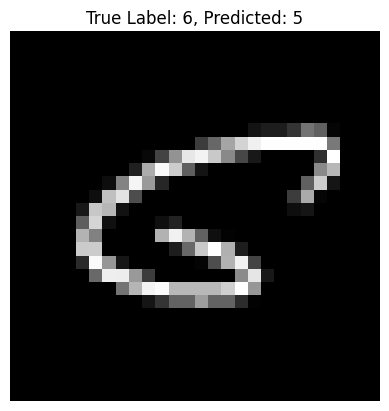

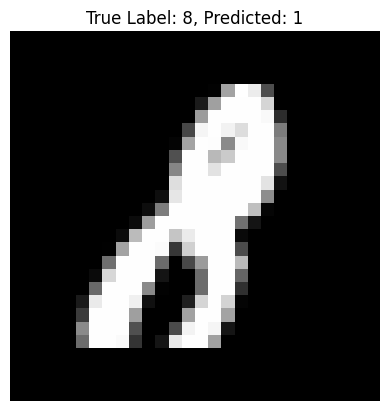

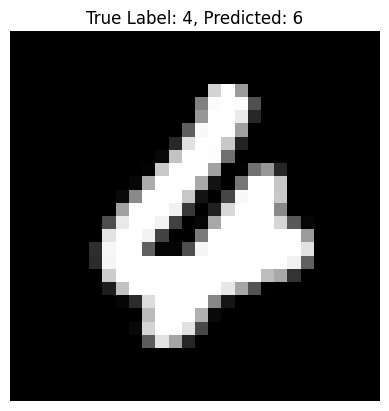

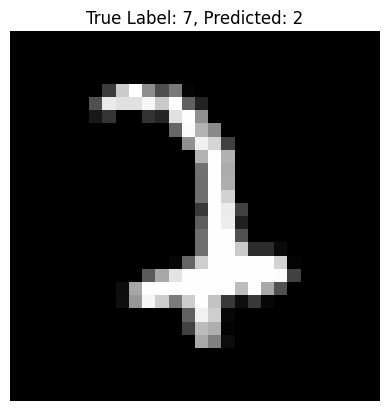

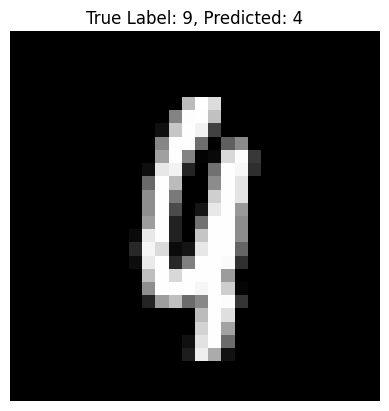

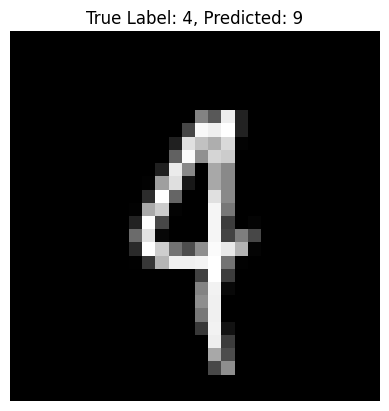

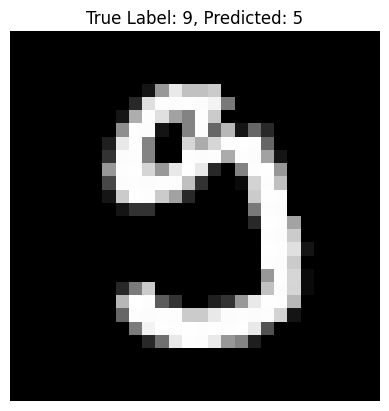

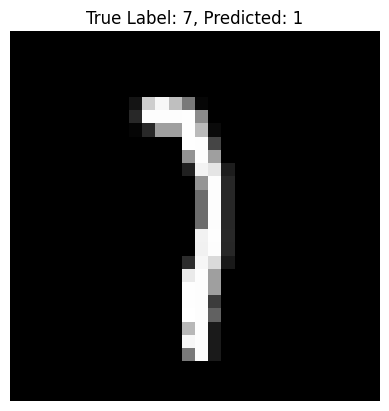

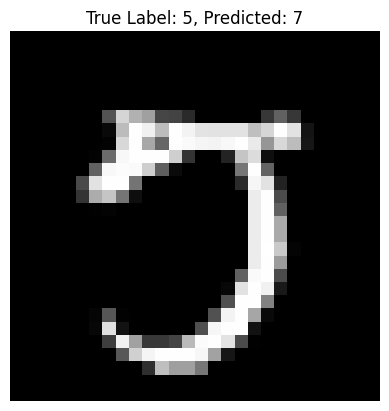

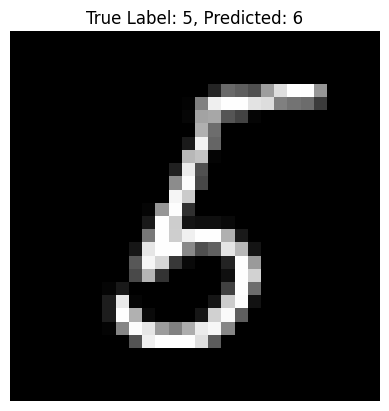

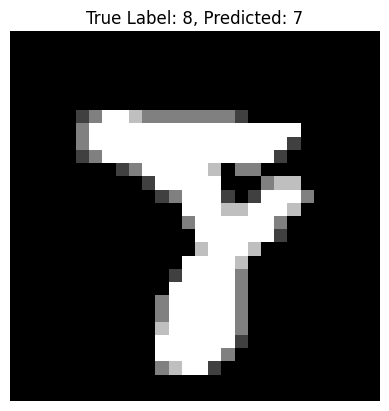

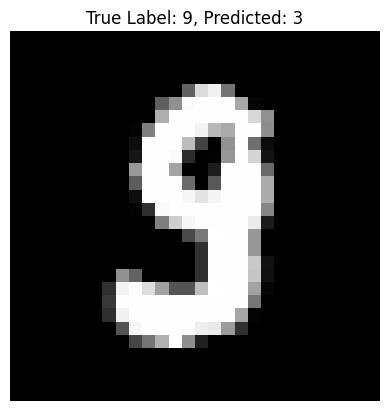

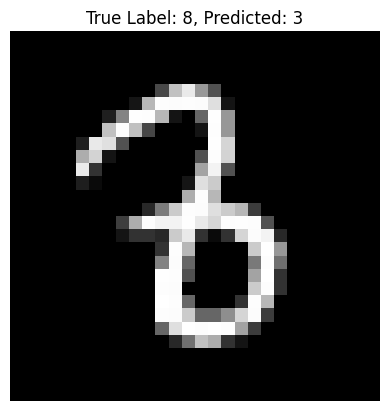

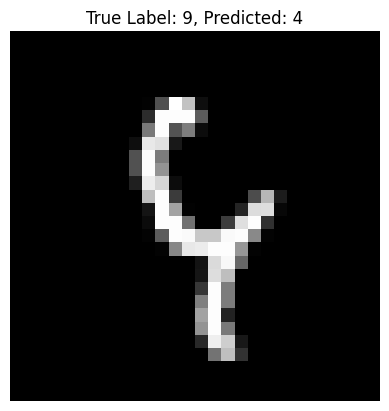

In [3]:
import matplotlib.pyplot as plt

incorrect_images = []
incorrect_labels = []
incorrect_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        incorrect_mask = predicted != labels
        incorrect_images.extend(images[incorrect_mask])
        incorrect_labels.extend(labels[incorrect_mask])
        incorrect_preds.extend(predicted[incorrect_mask])

for i in range(min(20, len(incorrect_images))):
    image = incorrect_images[i].squeeze().numpy()
    true_label = incorrect_labels[i].item()
    pred_label = incorrect_preds[i].item()
    
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()
